# Minibatch


Why are we re-writing things from scratch?

The idea is that we're trying to learn a library better. If we can't learn what the library does,  we can just re-implement the algorithm ourselves and then we'll be able to understand the library's functions.

In [1]:
#| default_exp minibatch

In [245]:
import torch
from torch import nn
import math

from __future__ import annotations

# Get the MNIST dataset
import gzip, pickle
import urllib.request
from pathlib import Path
import matplotlib.pyplot as plt

MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"
data_path = Path("../data")
data_path.mkdir(parents=True, exist_ok=True)
data_gz = data_path/"mnist.pkl.gz"

# Get the data
if not data_gz:
    urllib.request.urlretrieve(MNIST_URL, data_path/"mnist.pkl.gz")
    
# Destructuring
with gzip.open(data_gz, mode='rb') as unzip_data:
    obj = pickle.load(unzip_data, encoding="latin-1")
    ((x_train, y_train), (x_valid, y_valid), _) = obj

# To tensors
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

In [3]:
n, m = x_train.shape
c = int(y_train.max()+1)
nh = 50
n, m, c, nh

(50000, 784, 10, 50)

In [4]:
# Our model architecture from 03_backpropagation.ipynb

class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [
            nn.Linear(n_in, nh), # [784,50]
            nn.ReLU(),
            nn.Linear(nh, n_out) # [50,10]
        ]
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [5]:
model = Model(m, nh, c)
preds = model(x_train)
preds.shape # We are now going to use 10 categories for output

torch.Size([50000, 10])

## Implement `Cross Entropy Loss` function

In the last notebook, we used the MSE (L2-norm) to calculate the error. That function was not ideal for predicting multicategory classifications, like MNIST. Following, we are going to reconstruct the `cross entropy loss` function from scratch. 

The targets will be `on-hot-encoded` vectors with the index of a 1 representing the actual number.

**`Cross Entropy Loss` typically serves multi-class and multi-label classifications.**

`Cross Entropy Loss = log(SoftMax(i))`

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss:

In [6]:
# softmax: x.exp()/(x.exp().sum(dim=-1, keepdim=True))

def softmax(x):
    """ Softmax """
    return (x.exp()/(x.exp().sum(dim=-1, keepdim=True))).log()

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax:

In [7]:
#log(softmax(x)):
def log_softmax(x):
    return x - x.exp().sum(-1,keepdim=True).log()

In [8]:
log_softmax_preds = log_softmax(preds)
log_softmax_preds

tensor([[-2.2807, -2.5093, -2.3227,  ..., -2.2554, -2.3243, -2.1333],
        [-2.4135, -2.4360, -2.2427,  ..., -2.3645, -2.1714, -2.0787],
        [-2.3150, -2.3989, -2.1929,  ..., -2.3479, -2.1501, -2.1698],
        ...,
        [-2.3431, -2.3722, -2.2730,  ..., -2.2801, -2.2319, -2.1322],
        [-2.3011, -2.4860, -2.3119,  ..., -2.2380, -2.1589, -2.2805],
        [-2.3057, -2.4393, -2.1590,  ..., -2.3203, -2.2708, -2.2438]],
       grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

In `PyTorch` this is known as : negative log likelihood loss == `nll`

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

In [9]:
# First 3 numbers
y_train[0:3]

tensor([5, 0, 4])

In [10]:
log_softmax_preds.shape

torch.Size([50000, 10])

In [11]:
# The prababilities of the categories from above are
log_softmax_preds[0, 5], log_softmax_preds[1, 0], log_softmax_preds[2, 4]

(tensor(-2.2067, grad_fn=<SelectBackward0>),
 tensor(-2.4135, grad_fn=<SelectBackward0>),
 tensor(-2.4659, grad_fn=<SelectBackward0>))

In [12]:
log_softmax_preds[0, y_train[0]], log_softmax_preds[1, y_train[1]], log_softmax_preds[2, y_train[2]]

(tensor(-2.2067, grad_fn=<SelectBackward0>),
 tensor(-2.4135, grad_fn=<SelectBackward0>),
 tensor(-2.4659, grad_fn=<SelectBackward0>))

In [30]:
log_softmax_preds[[0,1,2], y_train[:3]]

tensor([-2.2067, -2.4135, -2.4659], grad_fn=<IndexBackward0>)

So, we have the `log(softmax(p))`. Now we need to implement the Cross entropy loss from above as the sum of those.

In [14]:
def nll(inp, target):
    """ Cross Entropy Loss """
    return -inp[range(target.shape[0]), target].mean()

In [15]:
loss = nll(log_softmax_preds, y_train)
loss

tensor(2.3065, grad_fn=<NegBackward0>)

### Going to PyTorch

`PyTorch` already has a function for `Cross Entropy Loss`, so we can use that.

In [16]:
import torch.nn.functional as F

# nll = negative log likelihood loss
F.nll_loss(F.log_softmax(preds, dim=1), y_train)

tensor(2.3065, grad_fn=<NllLossBackward0>)

The above combination of the 2 functions can be combined into 1:

In [17]:
F.cross_entropy(preds, y_train)

tensor(2.3065, grad_fn=<NllLossBackward0>)

## Basic training loop

1) get the predictions from the model
2) calculate the loss from the predictions (based on y_train)
3) calculate the gradients of the loss with respect to every parameter of the model
4) adjust the parameters according to their gradients and learning rate

In [18]:
loss_func = F.cross_entropy

In [19]:
bs = 64
xb = x_train[:bs] # minibatch from x
preds = model(xb)
preds[0], preds.shape

(tensor([ 0.0984, -0.1302,  0.0564, -0.0200,  0.0017,  0.1724,  0.1127,  0.1237,
          0.0548,  0.2458], grad_fn=<SelectBackward0>),
 torch.Size([64, 10]))

In [20]:
yb = y_train[:64]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [21]:
loss_func(preds, yb)

tensor(2.3205, grad_fn=<NllLossBackward0>)

We need to grab the highest probabilities of the predicted nubmers.

In [22]:
preds.argmax(dim=1)

tensor([9, 9, 8, 7, 5, 8, 8, 5, 8, 2, 9, 8, 9, 8, 8, 5, 9, 2, 8, 2, 5, 9, 2, 7,
        9, 9, 8, 2, 7, 2, 2, 2, 5, 8, 5, 2, 5, 8, 2, 7, 2, 2, 9, 2, 9, 5, 8, 5,
        9, 9, 7, 5, 2, 8, 5, 8, 5, 5, 5, 8, 2, 8, 9, 5])

And we define the accuracy:

In [101]:
#|export
def accuracy(preds:torch.tensor, targs:torch.tensor) -> float:
    """ The average of the correctly predicted numbers """
    return (preds.argmax(dim=1)==targs).float().mean()

In [99]:
accuracy(preds, yb)

tensor(1.)

In [102]:
#|export
def report(epoch:int, preds:torch.tensor, targs:torch.tensor, loss:float):
    """ Print a report after each epoch of training """
    print(f"epoch:{epoch} \t accuracy:{accuracy(preds, targs).item():.3f} \t loss:{loss.item():.5f}")

We have an accuracy of ~10% which is expected because of the random weights.

Let's setup the basic training loop:

In [26]:
# Recreate the model before running the training
model = Model(m, nh, c)

In [27]:
batch_size = 64
epochs = 3
lr = 0.5

for epoch in range(epochs):

    for i in range(0, x_train.shape[0], batch_size):
        
        # Create xb, yb batch - this operation is way slower than slice
        if i+batch_size > x_train.shape[0]:
            xb = x_train[i:]
            yb = y_train[i:]
        else:
            xb = x_train[i:i+batch_size] # x batch
            yb = y_train[i:i+batch_size] # y batch
            
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        loss.backward()
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, "weight"):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    print(f"epoch:{epoch} \t accuracy:{accuracy(preds, yb).item():.6f} \t loss:{loss.item():.6f}")

epoch:0 	 accuracy:0.875000 	 loss:0.289887
epoch:1 	 accuracy:1.000000 	 loss:0.109148
epoch:2 	 accuracy:1.000000 	 loss:0.031370


### Using `slice`

The `slice()` function returns a `slice object` that is used to slice any sequence (string, tuple, list, range, or bytes). So, we can use it to slice the training tensors.

In [28]:
model = Model(m, nh, c)

In [29]:
bs = 64
epochs = 3
lr = 0.5
n_inp = x_train.shape[0]

for epoch in range(epochs):
    for i in range(0, n_inp, 64):
        s = slice(i, min(n_inp, i + bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        loss.backward()
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, "weight"):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(epoch, preds, yb, loss)

epoch:0 	 accuracy:0.938 	 loss:0.28130
epoch:1 	 accuracy:1.000 	 loss:0.05041
epoch:2 	 accuracy:1.000 	 loss:0.03098


### PyTorch parameters

We are going to reduce the code size for the parameter update.

If we create an object which inherits from `nn.Module`, we can assign arbitrary parameters to it and traverse them as well:

In [37]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4)
m1.bar = nn.Linear(4, 1)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
  (bar): Linear(in_features=4, out_features=1, bias=True)
)

In [38]:
# This allows us to access the attributes of m1
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True)),
 ('bar', Linear(in_features=4, out_features=1, bias=True))]

In [39]:
# This prints the weights and bias matrices
list(m1.parameters())

[Parameter containing:
 tensor([[-0.1181, -0.0741, -0.3407],
         [-0.1159,  0.3236, -0.3029],
         [ 0.4393,  0.0018, -0.0367],
         [-0.0434, -0.0732,  0.1620]], requires_grad=True),
 Parameter containing:
 tensor([-0.5265,  0.3642, -0.4719,  0.4090], requires_grad=True),
 Parameter containing:
 tensor([[-0.3864,  0.4349,  0.1469, -0.3742]], requires_grad=True),
 Parameter containing:
 tensor([-0.4837], requires_grad=True)]

In [71]:
class MLP(nn.Module):
    """ Simple Multi Layer Perceptron to illustrate the use of parameter. """
    
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        """ Forward pass """
        return self.l2(self.relu(self.l1(x)))

In [55]:
model = MLP(m, nh, c)
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [56]:
for name, l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


You can access the parameteres (`weights` and `biases`) of each layer of the model:

In [57]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


That means, we can update them in the loop we hade defined before:

In [103]:
model = MLP(m, nh, c)
bs = 64
epochs = 3
lr = 0.5
n_inp = x_train.shape[0]

In [164]:
def fit(model=model, epochs=3):
    """ Basic loop using Torch model parameters to update their gradients. """
    for epoch in range(epochs):
        for i in range(0, n_inp, bs):
            s = slice(i, min(n_inp, i+bs))
            xb = x_train[s]
            yb = y_train[s]
            preds = model(xb) # We are now using the MLP model
            loss = F.cross_entropy(preds, yb)
            loss.backward()
            
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad*lr
                model.zero_grad() # Reset gradients for all model parameters
        report(epoch, preds, yb, loss)

In [142]:
fit()

epoch:0 	 accuracy:0.938 	 loss:0.20877
epoch:1 	 accuracy:0.938 	 loss:0.09138
epoch:2 	 accuracy:1.000 	 loss:0.06136


#### How it works in the background

In [118]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self, k, v):
        """ This is how PyTorch.nn.Module stores the children of the model. """
        if not k.startswith("_"):
            self._modules[k] = v
        super().__setattr__(k, v)
    
    def __repr__(self):
        return f"{self._modules}"
    
    def parameters(self):
        """ How to traverse parametes """
        for l in self._modules.values():
            yield from l.parameters()  

In [119]:
mymodel = MyModule(m, nh, c)
mymodel

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [122]:
for p in mymodel.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering layers in model - from scratch

How do we registers all the layers in our model at once?

In [149]:
# Suppose we store the layers in a variable
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c)]

In [134]:
class Model(nn.Module):
    
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers):
            self.add_module(f"layer_{i}", l) # This adds the modules to the module
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [137]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

It's apparent that **we're building a sequential model**.

#### Going to PyTorch - `nn.ModuleList()`

`PyTorch` allows use to add module with the `nn.ModuleList()` function.

https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#modulelist

In [153]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.linears = nn.ModuleList(layers) # Create sequential model

    def forward(self, x):
        for i, l in enumerate(self.linears):
            x = l(x)
        return x
        # return reduce(lambda val,layer: layer(val), self.layers, x)
    # Python reduce: https://realpython.com/python-reduce-function/

In [154]:
seqmodel = SequentialModel(layers)
seqmodel

SequentialModel(
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [151]:
fit(model=seqmodel)

epoch:0 	 accuracy:0.938 	 loss:0.26509
epoch:1 	 accuracy:1.000 	 loss:0.05742
epoch:2 	 accuracy:1.000 	 loss:0.03991


#### Going to PyTorch - `nn.Sequential()`

In [162]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [163]:
fit(model=model)

epoch:0 	 accuracy:0.938 	 loss:0.26006
epoch:1 	 accuracy:0.938 	 loss:0.12742
epoch:2 	 accuracy:1.000 	 loss:0.04654


### SGD Optimizer - from scratch

Finding the gradients of the layers and updating the parameters is a common step. An optimizer is a function which does that for us.

```Python
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad*lr
    model.zero_grad() # Reset gradients for all model parameters
```

Let's create our own `optimizer`.

In [184]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr
                
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [197]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

In [198]:
# We create opt as an object of the model's parameters
opt = Optimizer(model.parameters())

In [199]:
# New training loop

for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb = x_train[s]
        yb = y_train[s]
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        loss.backward()
        
        # Out custom optimizer
        opt.step()
        opt.zero_grad()
    report(epoch, preds, yb, loss)

epoch:0 	 accuracy:0.938 	 loss:0.27777
epoch:1 	 accuracy:0.938 	 loss:0.12077
epoch:2 	 accuracy:1.000 	 loss:0.06665


PyTorch provides the same functionality with `optim.SGD`.

#### Going to PyTorch - `optim.SGD`.

In [200]:
from torch import optim

In [201]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
opt = optim.SGD(model.parameters(), lr=0.5)

In [202]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb = x_train[s]
        yb = y_train[s]
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        loss.backward()
        
        # PyTorch's SGD optimizer
        opt.step()
        opt.zero_grad()
    report(epoch, preds, yb, loss)

epoch:0 	 accuracy:0.938 	 loss:0.24661
epoch:1 	 accuracy:0.938 	 loss:0.08220
epoch:2 	 accuracy:1.000 	 loss:0.06311


In [340]:
#|export
def get_lin_model():
    _model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
    _opt = optim.SGD(_model.parameters(), lr=0.5)
    return _model, _opt

## Dataset and DataLoader

We're going to create the `Dataset` and `DataLoader` from scratch to understand how they're implemented in `PyTorch`.

### Dataset

We'll go from:

```python
s = slice(i, min(i+bs, n))
xb = x_train[s]
yb = y_train[s]
```

to

```python
xb,yb = train_ds[s]
```

In [229]:
#|export
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, s):
        """ Slicing function: replaced slice() """
        return self.x[s], self.y[s]

In [230]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(y_valid)

In [231]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [226]:
model, opt = get_lin_model()

In [227]:
# New fit function with Dataset class
def fit(model = model, opt = opt):
    for epoch in range(epochs):
        for i in range(0, n, bs):
            xb, yb = train_ds[i:min(n, i+bs)]
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(epoch, preds, yb, loss)

In [228]:
fit()

epoch:0 	 accuracy:0.938 	 loss:0.20341
epoch:1 	 accuracy:1.000 	 loss:0.08491
epoch:2 	 accuracy:1.000 	 loss:0.05776


### DataLoader

We are going to replace:

```Python
for i in range(0, n, bs):
    xb, yb = train_ds[i:min(n, i+bs)]
```
with:
```Python
for xb, yb in train_dl:
    ...
```

So we need to create an itterator with `__iter__()` and `yield`.

In [238]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:min(len(self.ds), i+self.bs)]

In [254]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [241]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [242]:
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

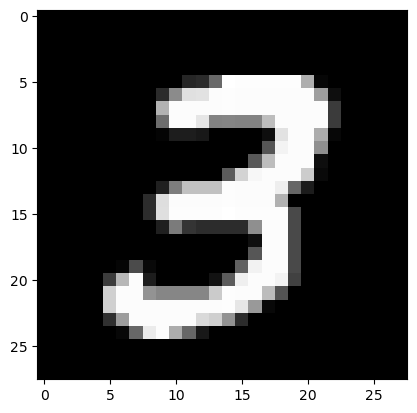

In [250]:
plt.imshow(xb[7].view(28, 28), cmap='gray')

In [255]:
model, opt = get_lin_model()

In [256]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(epoch, preds, yb, loss)

In [257]:
fit()

epoch:0 	 accuracy:0.875 	 loss:0.25264
epoch:1 	 accuracy:0.938 	 loss:0.16140
epoch:2 	 accuracy:0.938 	 loss:0.10023


### Batch randomizer

Now, we have created a way to load datasets into the traininig function. However, the DataLoaderes are sequential - they fetch items in a sequence.

One feature we can add to the `DataLoader` is a shuffler, which fetches random data from the training set.

In [258]:
import random

In [274]:
class Sampler():
    
    def __init__(self, ds, shuffle=False):
        self.n = len(ds)
        self.shuffle = shuffle
        
    def __iter__(self):
        """ Returns the indexes which we're going to use to create xb and yb"""
        result = list(range(self.n))
        if self.shuffle:
            random.shuffle(result)
        return iter(result)

In [269]:
from itertools import islice

In [275]:
ss = Sampler(train_ds) # If shuffle==False
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [278]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[27911, 9797, 3179, 6012, 2541]

Now we can create random indexes for a single batch.

In [295]:
import fastcore.all as fc

In [310]:
class BatchSampler():
    """ Creates batch size Sampler slices. """
    def __init__(self, sampler, bs, drop_last=False):
        fc.store_attr()
    def __iter__(self):
        """ Returns batches of indexes """
        yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [301]:
batchs = BatchSampler(ss, 10)
list(islice(batchs, 10))

[[29348, 35338, 48222, 29460, 44853, 23000, 686, 9575, 48456, 8354],
 [29636, 35043, 14874, 4380, 13282, 31218, 25690, 1776, 22751, 8994],
 [11889, 6814, 3475, 24362, 21516, 34221, 29525, 29915, 45333, 36024],
 [42387, 12043, 46853, 22491, 4885, 9829, 31501, 33843, 36958, 22575],
 [42556, 5201, 5470, 19905, 13092, 28590, 9475, 17238, 34363, 23070],
 [12236, 812, 16667, 18688, 11400, 47723, 4271, 12877, 24966, 28019],
 [36065, 27811, 18273, 44961, 21658, 23411, 6569, 13712, 19907, 8099],
 [47989, 16975, 6621, 6945, 47815, 21232, 17006, 7387, 43863, 4304],
 [47577, 7338, 24473, 15429, 12262, 3224, 4245, 2511, 49857, 12969],
 [45787, 5109, 12028, 21551, 35988, 46082, 19365, 48860, 25614, 7778]]

Now we can create batches of random indexes using `Sampler()` and `BatchSampler()`.

However, we need to be returning `torch.Tensors`:

In [307]:
def collate(b):
    """ Splits the x and y into the different tensors """
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [308]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate):
        fc.store_attr() # Stores everything in __init__() in a self variable
        
    def __iter__(self):
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [312]:
# Create the batch size indexes
train_sample = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_sample = BatchSampler(Sampler(train_ds, shuffle=False), bs)

In [313]:
# Create the actual iterators over the training and validation Datasets
train_dl = DataLoader(train_ds, batchs=train_sample)
valid_dl = DataLoader(valid_ds, batchs=valid_sample)

In [323]:
xb, yb = next(iter(train_dl)) # That should fetch an xb shuffled

In [324]:
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

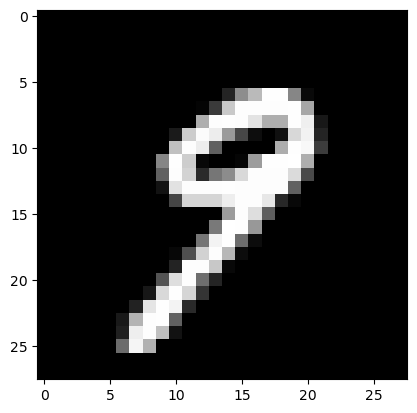

In [325]:
plt.imshow(xb[50].view(28, 28), cmap="gray")

In [326]:
model, opt = get_lin_model()

In [327]:
fit()

epoch:0 	 accuracy:0.875 	 loss:0.50107
epoch:1 	 accuracy:1.000 	 loss:0.08248
epoch:2 	 accuracy:1.000 	 loss:0.12113


The `PyTorch`'s `DataLoaders` work exactly like the implementation above. However, it runs in parallel when the `DataLoader` class.

**I skipped implementing the parallel `DataLoader`.**

### Going to `PyTorch` `DataLoader`

In [341]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [342]:
# Create the batch size indexes
train_sample = BatchSampler(RandomSampler(train_ds), batch_size=bs, drop_last=False)
valid_sample = BatchSampler(Sampler(train_ds, shuffle=False), batch_size=bs, drop_last=False)

In [343]:
# Create the DataLoaders using the indexes from above
train_dl = DataLoader(train_ds, batch_sampler=train_sample, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_sample, collate_fn=collate)

In [346]:
model, opt = get_lin_model()
fit()

epoch:0 	 accuracy:0.938 	 loss:0.28049
epoch:1 	 accuracy:1.000 	 loss:0.09918
epoch:2 	 accuracy:1.000 	 loss:0.01024


OR

In [347]:
train_dl = DataLoader(train_ds, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [348]:
model, opt = get_lin_model()
fit()

epoch:0 	 accuracy:0.000 	 loss:2.38125
epoch:1 	 accuracy:0.000 	 loss:2.73254
epoch:2 	 accuracy:1.000 	 loss:1.69010


#### Shorter version

In [349]:
# A much shorter version which does everything together
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [350]:
model, opt = get_lin_model()
fit()

epoch:0 	 accuracy:0.922 	 loss:0.21675
epoch:1 	 accuracy:0.938 	 loss:0.11969
epoch:2 	 accuracy:0.984 	 loss:0.04421


## Validation

We've improved out basic training loop. Now, we need to see how it's performing on the validation dataset.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [368]:
#|export

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            train_preds = model(xb)
            train_loss = loss_func(train_preds, yb)
            train_loss.backward()
            opt.step()
            opt.zero_grad()
        # Print training report
        report(epoch, train_preds, yb, train_loss)
        
        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb, yb in valid_dl:
                valid_preds = model(xb)
                n = len(xb) # batch size?
                count += n # Why?
                tot_loss += loss_func(valid_preds, yb).item()*n # Why multiply?
                tot_acc += accuracy(valid_preds, yb)*n
        print(f"epoch:{epoch}\t valid accuracy: {tot_acc/count:.3}\t valid loss: {tot_loss/count:.3}")
    return tot_loss/count, tot_acc/count

In [369]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2, **kwargs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2, **kwargs)
    return(train_dl, valid_dl)

In [370]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_lin_model()

In [371]:
%time loss, acc = fit(5, model, F.cross_entropy, opt, train_dl, valid_dl)

epoch:0 	 accuracy:0.953 	 loss:0.13715
epoch:0	 valid accuracy: 0.951	 valid loss: 0.161
epoch:1 	 accuracy:0.984 	 loss:0.04575
epoch:1	 valid accuracy: 0.965	 valid loss: 0.126
epoch:2 	 accuracy:1.000 	 loss:0.01689
epoch:2	 valid accuracy: 0.965	 valid loss: 0.116
epoch:3 	 accuracy:1.000 	 loss:0.04276
epoch:3	 valid accuracy: 0.969	 valid loss: 0.105
epoch:4 	 accuracy:0.984 	 loss:0.05489
epoch:4	 valid accuracy: 0.97	 valid loss: 0.103
CPU times: user 16.4 s, sys: 1.02 s, total: 17.4 s
Wall time: 5.06 s


# Export

In [372]:
import nbdev; nbdev.nbdev_export()